In [1]:
import skhep_testdata, uproot

tree = uproot.open(skhep_testdata.data_path("uproot-Zmumu.root"))["events"]

import numpy as np

np.histogram(tree["M"].array())

<Array [[172, 89, 29, 69, 277, ..., 24, 0, 2, 2], ...] type='2 * var * float64'>

(array([ 172.,   89.,   29.,   69.,  277., 1640.,   24.,    0.,    2.,
           2.]),
 array([  0.38905792,  17.56032889,  34.73159987,  51.90287084,
         69.07414181,  86.24541279, 103.41668376, 120.58795473,
        137.75922571, 154.93049668, 172.10176766]),
 <BarContainer object of 10 artists>)

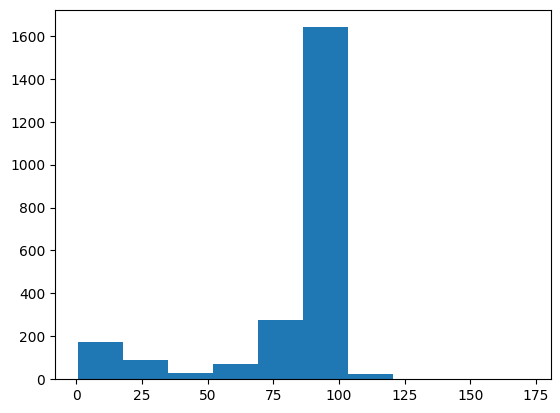

In [2]:
import matplotlib.pyplot as plt

plt.hist(tree["M"].array())

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x16955bdd0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

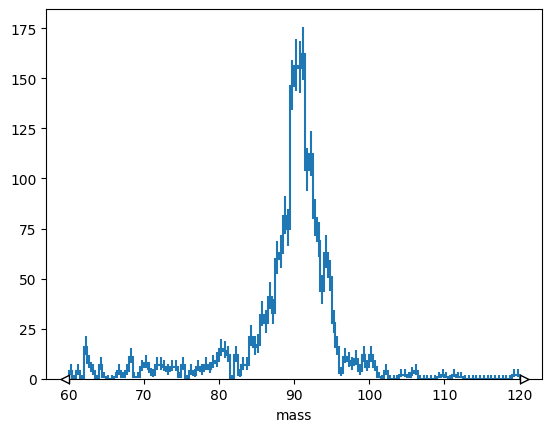

In [4]:
import boost_histogram as bh
import hist

h = hist.Hist(hist.axis.Regular(120, 60, 120, name="mass"))

h.fill(tree["M"].array())

h.plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x11ac30590>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

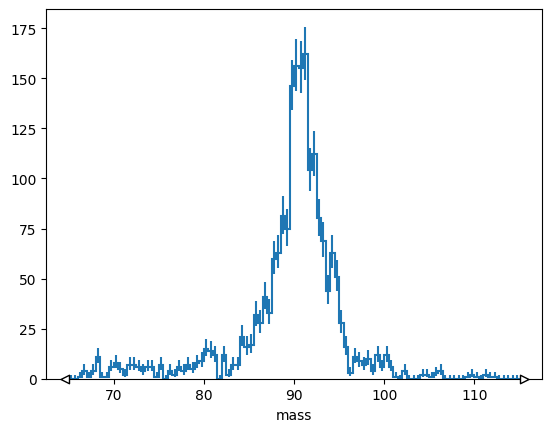

In [5]:
h[10:110].plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x176fcfad0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

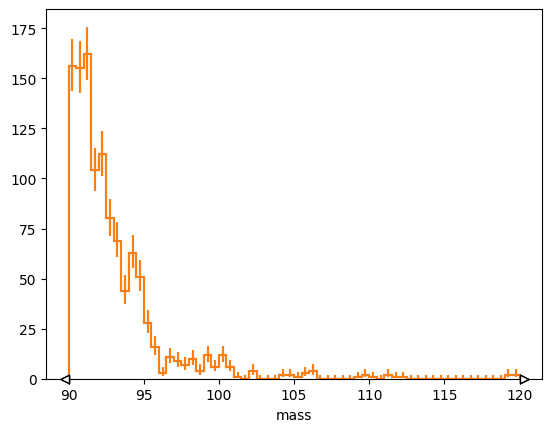

In [6]:
# Explicit version
h[hist.loc(90) :].plot()

# Short version
h[90j:].plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x177309f10>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

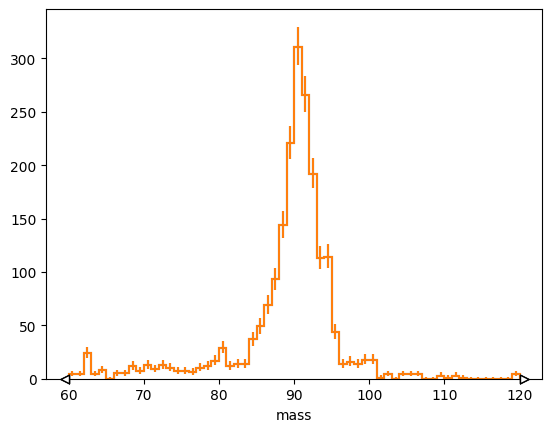

In [7]:
# Explicit version
h[:: hist.rebin(2)].plot()

# Short version
h[::2j].plot()

In [8]:
# Explicit version
h[hist.loc(80) : hist.loc(100) : sum]

# Short version
h[90j:100j:sum]

1102.0

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x178aec3d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

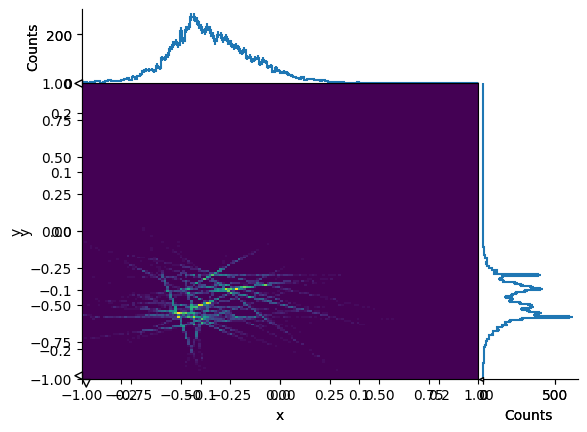

In [12]:
import uproot
import hist
import awkward as ak

picodst = uproot.open(
    "https://pivarski-princeton.s3.amazonaws.com/pythia_ppZee_run17emb.picoDst.root:PicoDst"
)

vertexhist = hist.Hist(
    hist.axis.Regular(600, -1, 1, label="x"),
    hist.axis.Regular(600, -1, 1, label="y"),
    hist.axis.Regular(40, -200, 200, label="z"),
)

vertex_data = picodst.arrays(filter_name="*mPrimaryVertex[XYZ]")

vertexhist.fill(
    ak.flatten(vertex_data["Event.mPrimaryVertexX"]),
    ak.flatten(vertex_data["Event.mPrimaryVertexY"]),
    ak.flatten(vertex_data["Event.mPrimaryVertexZ"]),
)

vertexhist[:, :, sum].plot2d_full()
vertexhist[-0.25j:0.25j, -0.25j:0.25j, sum].plot2d_full()
vertexhist[sum, sum, :].plot()
vertexhist[-0.25j:0.25j:sum, -0.25j:0.25j:sum, :].plot()

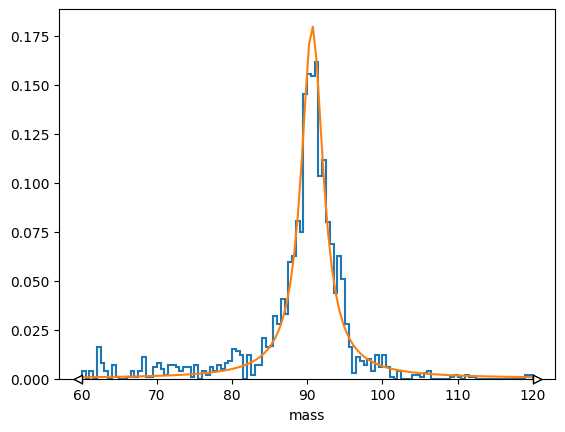

In [15]:
import numpy as np
import iminuit.cost

norm = len(h.axes[0].widths) / (h.axes[0].edges[-1] - h.axes[0].edges[0]) / h.sum()


def f(x, background, mu, gamma):
    return (
        background
        + (1 - background) * gamma**2 / ((x - mu) ** 2 + gamma**2) / np.pi / gamma
    )


loss = iminuit.cost.LeastSquares(
    h.axes[0].centers, h.values() * norm, np.sqrt(h.variances()) * norm, f
)
loss.mask = h.variances() > 0

minimizer = iminuit.Minuit(loss, background=0, mu=91, gamma=4)

minimizer.migrad()
minimizer.hesse()

(h * norm).plot()
plt.plot(loss.x, f(loss.x, *minimizer.values))

/Users/thiagorangel/anaconda3/envs/ROOT/lib/python3.11/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x19401fc50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

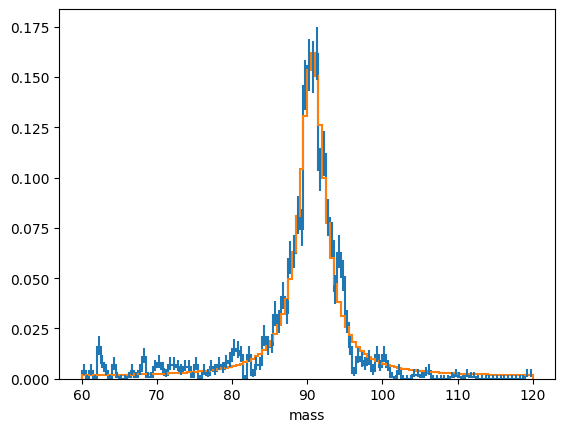

In [18]:
import zfit

binned_data = zfit.data.BinnedData.from_hist(h)

binning = zfit.binned.RegularBinning(120, 60, 120, name="mass")
space = zfit.Space("mass", binning=binning)

background = zfit.Parameter("background", 0)
mu = zfit.Parameter("mu", 91)
gamma = zfit.Parameter("gamma", 4)
unbinned_model = zfit.pdf.SumPDF(
    [zfit.pdf.Uniform(60, 120, space), zfit.pdf.Cauchy(mu, gamma, space)], [background]
)

model = zfit.pdf.BinnedFromUnbinnedPDF(unbinned_model, space)
loss = zfit.loss.BinnedNLL(model, binned_data)

minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(loss)

binned_data.to_hist().plot(density=1)
model.to_hist().plot(density=1)